In [57]:
DATADIR = './' # unzipped train and test data
OUTDIR = './model-output' # just a random name
# Data Loading
import os
import re
from glob import glob


POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}

import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

def load_data(data_dir):
    """ Return 2 lists of tuples:
    [(class_id, user_id, path), ...] for train
    [(class_id, user_id, path), ...] for validation
    """
    # Just a simple regexp for paths with three groups:
    # prefix, label, user_id
    pattern = re.compile("(.+\/)?(\w+)\/([^_]+)_.+wav")
    all_files = glob(os.path.join(data_dir, 'train/audio/*/*wav'))

    with open(os.path.join(data_dir, 'train/validation_list.txt'), 'r') as fin:
        validation_files = fin.readlines()
    valset = set()
    for entry in validation_files:
        r = re.match(pattern, entry)
        if r:
            valset.add(r.group(3))

    possible = set(POSSIBLE_LABELS)
    train, val = [], []
    for entry in all_files:
        r = re.match(pattern, entry)
        if r:
            label, uid = r.group(2), r.group(3)
            if label == '_background_noise_':
                label = 'silence'
            if label not in possible:
                label = 'unknown'

            label_id = name2id[label]

            sample = (label_id, uid, entry)
            if uid in valset:
                val.append(sample)
            else:
                train.append(sample)

    print('There are {} train and {} val samples'.format(len(train), len(val)))
    return train, val

trainset, valset = load_data(DATADIR)

There are 347538 train and 6798 val samples


In [51]:
from tqdm import tqdm

trainset_df = pd.DataFrame(trainset)
input_dir = '/home/dannyp/repos/tensorflow-samples'
noise_file = '/train/audio/_background_noise_/exercise_bike.wav'
noise_type = 'bike'
noise_sample_rate, noise_wav = wavfile.read(input_dir + noise_file)
out_dir = '/home/dannyp/repos/tensorflow-samples/train_augmented/audio/'
noise_sample_rate, noise_wav = wavfile.read(input_dir + noise_file)

def augment_wav (wav, noise_wav, noise_param):
    L = wav.shape[0] 
    L_noise = len(noise_wav)
    if L_noise > L:
        beg = np.random.randint(0, len(noise_wav) - L)
        noise_mask=noise_wav[beg: beg + L]
        augmented_wav = (1 - noise_param) * wav + (noise_param * noise_mask)
        return augmented_wav
    else:
        return wav

for row in tqdm(range(len(trainset))):

    train_file = trainset_df.loc[row][2]
    file_id = trainset_df.loc[row][2][-21:-4]
    label_id = trainset_df.loc[row][2][14:-22]
    if ('background' in label_id):
        continue
    sample_rate, wav = wavfile.read(input_dir + train_file[1:])
    noise_param = 0.02
    augmented_wav = augment_wav(wav, noise_wav, noise_param)
    wavfile.write(filename= str(out_dir + label_id + '/' + file_id + '_' + noise_type + '.wav'),
                  rate=sample_rate,
                  data = augmented_wav)

/home/dannyp/Installed/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
100%|██████████| 57929/57929 [01:38<00:00, 585.26it/s]


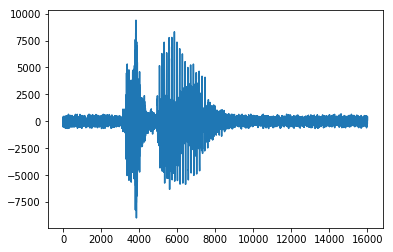

In [46]:
%matplotlib inline
row = 100

train_file = trainset_df.loc[row][2]
file_id = trainset_df.loc[row][2][-21:-4]
label_id = trainset_df.loc[row][2][14:-22]
sample_rate, wav = wavfile.read(input_dir + train_file[1:])
noise_param = 0.02
augmented_wav = augment_wav(wav, noise_wav, noise_param)
wavfile.write(filename= str(out_dir + label_id + '/' + file_id + '_' + noise_type + '.wav'),
              rate=sample_rate,
              data = augmented_wav)

plt.plot(augmented_wav)